In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
DATASET_PATH = '/kaggle/input/webmarket-dataset/'
IMAGE_PATH = 'db1/db1/db1/db102.jpg'
TRAIN_SPLIT_PCNTG = 0.7
VALIDATION_SPLIT_PCNTG = 0.15
#TEST_SPLIT_PCNTG = 0.15 # Left of above 2, thus not used

In [3]:
import os
import pandas as pd

import torch
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder

from torchvision.models.detection import fcos_resnet50_fpn

from torchvision.utils import draw_bounding_boxes
from matplotlib import pyplot as plt

import random

Text(0.5, 1.0, 'Displaying image db231.jpg')

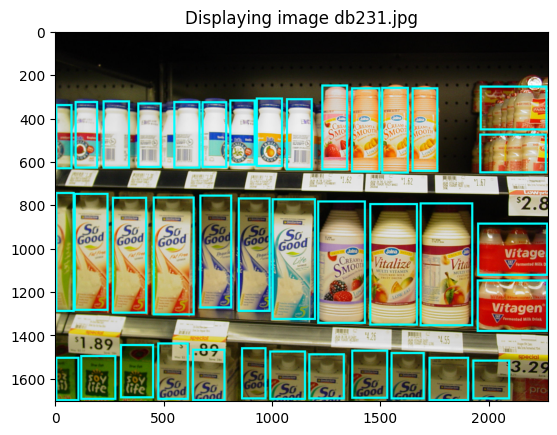

In [4]:
class WebMarket(Dataset):
    def __init__(self,dataset_path):
        self.dataset_path = dataset_path
        self.annotation = pd.read_csv(os.path.join(DATASET_PATH,'db1_data.csv'))
        
        self.img_dir = 'db1/db1/db1'
        self.meta = os.listdir(os.path.join(self.dataset_path,self.img_dir))
        self.meta.sort()
        
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.annotation['class'])
        self.annotation['class'] = self.label_encoder.transform(self.annotation['class'])
        

    def __len__(self):
        return len(self.meta)

    def __getitem__(self,idx):
        img_name = self.meta[idx]
        img = read_image(os.path.join(self.dataset_path, self.img_dir, img_name))
        
        annotation = self.annotation[self.annotation['filename']==img_name]
        bboxes = torch.tensor(annotation[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy())
        labels = annotation['class'].values
        annotation = {
            'bboxes': bboxes,
            'labels': labels,
            'image_id': img_name[2:-4]
        }
        return img,annotation
    
webMarket = WebMarket(DATASET_PATH)

random.seed(2048)
rand_id = random.randint(0, len(webMarket))
img,annots = webMarket[rand_id]
plt.imshow(draw_bounding_boxes(img, annots['bboxes'], colors='cyan', width=10).permute(1,2,0))
plt.title(f'Displaying image db{annots["image_id"]}.jpg')

In [5]:
sampler = list(range(0,300))
random.seed(2048)
random.shuffle(sampler)

train_sampler = sampler[:int(len(webMarket)*TRAIN_SPLIT_PCNTG)]
validation_sampler = sampler[len(train_sampler) : len(train_sampler) + int(len(webMarket)*VALIDATION_SPLIT_PCNTG)]
test_sampler = sampler[len(train_sampler) + len(validation_sampler): ]

train_data_loader = DataLoader(webMarket, batch_size=4, sampler=train_sampler)
validation_data_loader = DataLoader(webMarket, batch_size=4, sampler=validation_sampler)
test_data_loader = DataLoader(webMarket, batch_size=4, sampler=test_sampler)